In [21]:
import json
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import random

from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor, default_argument_parser, default_setup
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog

from deepent.data.register_datasets import register_datasets
from deepent.config import add_deepent_config

In [32]:
register_datasets(f'/home/ubuntu/RGBD-Tree-Segs-Clean/')

Registering Kelowna_train


AssertionError: Dataset 'Kelowna_train' is already registered!

In [23]:
config_file = '../configs/deepent_fuse_rcnn_R_50_FPN.yaml'
threshold = 0.5
model = '../output/baseline_fuse_07_02_2020/model_0089999.pth'
samples = 1
dataset = 'CPT2a-n_train'
type_ = 'many'
opts = []

class Args:
    def __init__(self, conf, tr, mod, sam, ty, opt, dts):
        self.config_file = conf
        self.threshold = tr
        self.model = mod
        self.samples = sam
        self.dataset = dts
        self.type = ty
        self.opts = []
        self.output = None
        
args = Args(config_file, threshold, model, samples, type_, opts, dataset)

In [24]:
with open(config_file, 'r') as f:
    print(f.read())

_BASE_: "Base-DeepEnt-RCNN-FPN.yaml"
MODEL:
  WEIGHTS: "detectron2://ImageNetPretrained/MSRA/R-50.pkl"
  MASK_ON: True
  RESNETS:
    DEPTH: 50
  PIXEL_MEAN: [120.961, 125.623, 111.1, 82.9653]
  PIXEL_STD: [1.0, 1.0, 1.0, 1.0]



In [25]:
cfg = get_cfg()
add_deepent_config(cfg)
cfg.merge_from_file(config_file)
cfg.merge_from_list(opts)
cfg.MODEL.WEIGHTS = model 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold 
cfg.freeze()
default_setup(cfg, args)

[03/14 04:43:34 detectron2]: Rank of current process: 0. World size: 1
[03/14 04:43:34 detectron2]: Environment info:
------------------------  -------------------------------------------------------------------
sys.platform              linux
Python                    3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) [GCC 7.2.0]
Numpy                     1.15.4
Detectron2 Compiler       GCC 5.4
Detectron2 CUDA Compiler  10.1
DETECTRON2_ENV_MODULE     <not set>
PyTorch                   1.3.1
PyTorch Debug Build       False
torchvision               0.4.2
CUDA available            True
GPU 0                     Tesla T4
CUDA_HOME                 /usr/local/cuda-10.1
NVCC                      Cuda compilation tools, release 10.1, V10.1.243
Pillow                    6.2.2
cv2                       4.1.2
------------------------  -------------------------------------------------------------------
PyTorch built with:
  - GCC 7.3
  - Intel(R) Math Kernel Library Version 2018.0.3 Produ

In [33]:
from tools.predictor import RGBDPredictor
predictor = RGBDPredictor(cfg)

# data = list(DatasetCatalog.get(args.dataset))
# metadata = MetadataCatalog.get(args.dataset)
# output = os.path.join(os.path.realpath(cfg.OUTPUT_DIR if args.output is None else args.output), args.dataset) 
# prefix = os.path.basename(args.model).split('.')[0]+'_thresh'+str(args.threshold)+'_'

[03/14 04:46:47 fvcore.common.checkpoint]: Loading checkpoint from ../output/baseline_fuse_07_02_2020/model_0089999.pth
[03/14 04:46:48 fvcore.common.checkpoint]: Some model parameters are not in the checkpoint:
  backbone.bottom_up.fuse_res2.fuse_out.{weight, bias}
  backbone.bottom_up.fuse_res3.fuse_out.{weight, bias}
  backbone.bottom_up.fuse_res4.fuse_out.{weight, bias}
  backbone.bottom_up.fuse_res5.fuse_out.{weight, bias}


In [34]:
predictor
data = list(DatasetCatalog.get("CPT2b_test"))
metadata = MetadataCatalog.get("CPT2b_test")

ValueError: operands could not be broadcast together with shapes (640,640,1) (640,640,4) (640,640,3) 

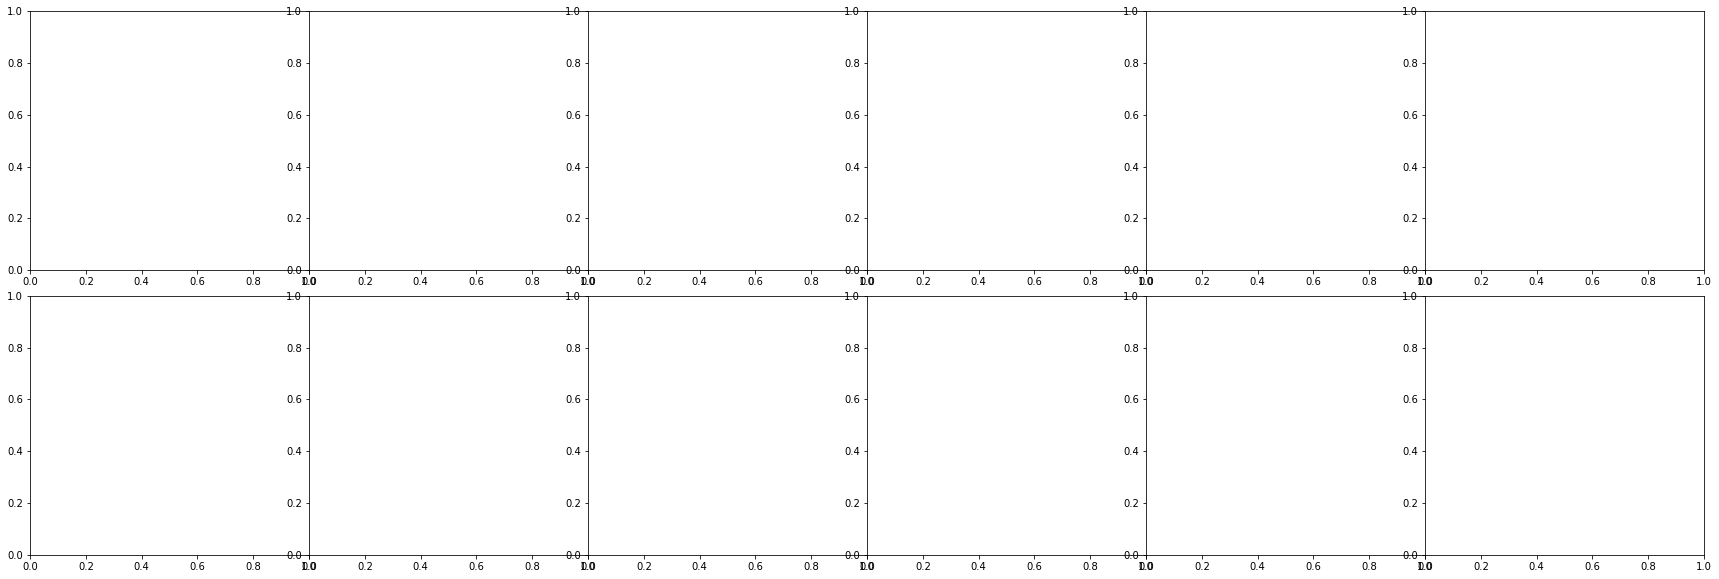

In [43]:
h = 10
fig, axes = plt.subplots(2,6, figsize=(3*h,h))
fig.subplots_adjust(hspace=.1, wspace=0)
i = 334
for ax in axes.ravel():
    dic = data[i]
    img = cv2.imread(dic["file_name"],cv2.IMREAD_UNCHANGED)
    predictions = predictor(img)
    visualizer = Visualizer(img, metadata=metadata) # instance_mode=ColorMode.IMAGE_BW
    z = visualizer.draw_instance_predictions(predictions["instances"].to("cpu"))
    vis = visualizer.draw_instance_predictions(predictions["instances"].to("cpu")).get_image()
    ax.imshow(vis)
    ax.set_axis_off()
    i += 1
# plt.savefig('poster_demo.png')

In [41]:
z

Instances(num_instances=0, image_height=640, image_width=640, fields=[pred_boxes = Boxes(tensor([], size=(0, 4))), scores = tensor([]), pred_classes = tensor([], dtype=torch.int64), pred_masks = tensor([], size=(0, 640, 640), dtype=torch.uint8), ])

In [23]:
dic = data[334]
img = cv2.imread(dic["file_name"])
predictions = predictor(img)

In [83]:
mask = Visualizer(img, metadata=metadata).draw_instance_predictions(predictions["instances"].to("cpu")).get_image()

In [20]:
import matplotlib.pyplot as plt

In [9]:
dic["file_name"]

'/home/ubuntu/RGBD-Tree-Segs/test/CPT2a-n/tile_113.png'

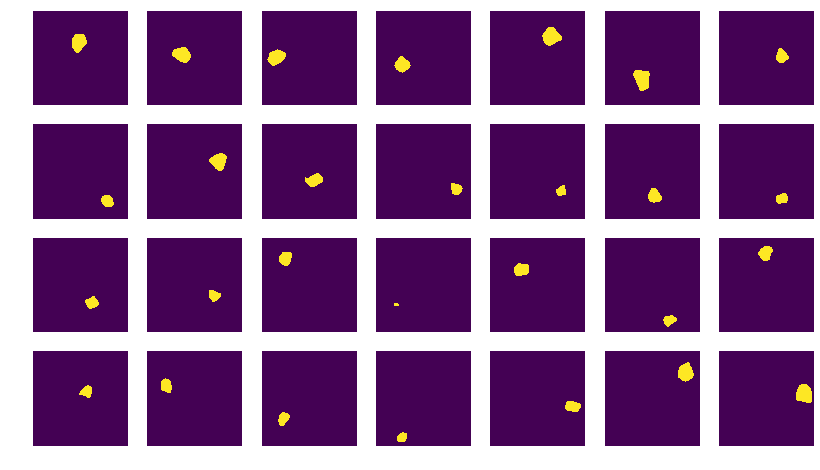

In [24]:
masks = predictions['instances'].pred_masks.cpu().numpy()
fig, axes = plt.subplots(4,7,figsize=(14,8))
for ax, mask in zip(axes.ravel(), masks):
    ax.imshow(mask)
    ax.set_axis_off()

In [25]:
mask = predictions['instances'].pred_masks.cpu().numpy()[0]
masks = np.where(mask==False,0,1)

for mask in predictions['instances'].pred_masks.cpu().numpy()[1:]:
    masks += np.where(mask==False,0,1)

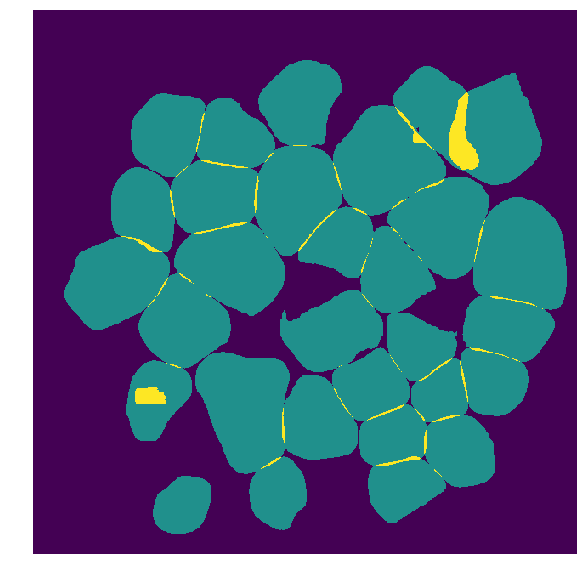

In [26]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.imshow(masks)
ax.set_axis_off()

masks

In [27]:
with open('m.json', 'w') as f:
    f.write(json.dumps([[float(y) for y in x] for x in masks]))

<module 'json' from '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/json/__init__.py'>

In [28]:
s = [x['segmentation'] for x in dic['annotations']]
with open('seg.json', 'w') as f:
    f.write(json.dumps(s))

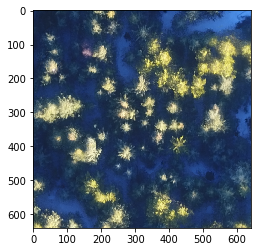

In [14]:
img = cv2.imread(dic["file_name"])
plt.imshow(img)

In [29]:
dic["file_name"]

'/home/ubuntu/RGBD-Tree-Segs/train/CPT2a-n/tile_334.png'

In [30]:
m=np.where(predictions['instances'].pred_masks.cpu().numpy()[0]==False,0.,1.)

In [37]:
with open('om.json','w') as f:
    f.write(json.dumps(m.tolist()))

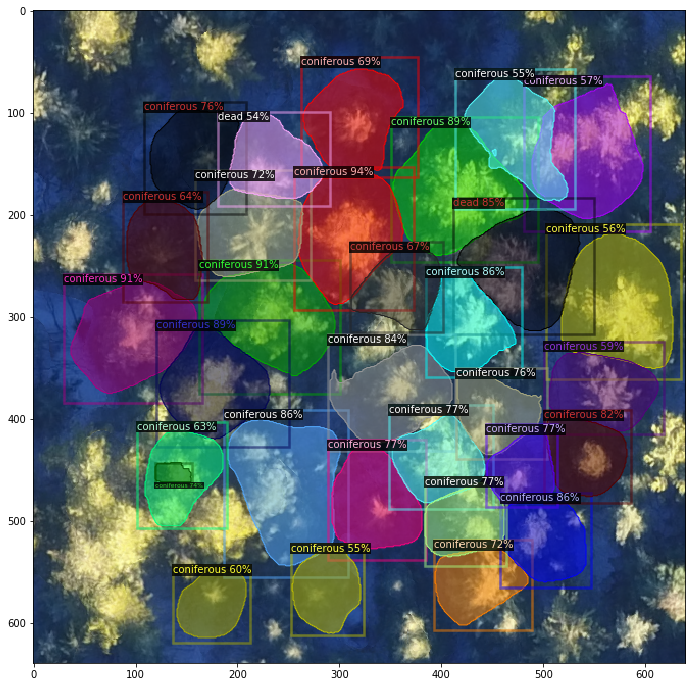

In [44]:
plt.figure(figsize=(12,12))
predictions = predictor(img)
visualizer = Visualizer(img, metadata=metadata) # instance_mode=ColorMode.IMAGE_BW
vis = visualizer.draw_instance_predictions(predictions["instances"].to("cpu")).get_image()
plt.imshow(vis)



In [6]:
import os
from glob import glob
import json

import cv2
import numpy as np
import shapefile

from detectron2.utils.visualizer import GenericMask

In [42]:
class Untiler:
    def __init__(self, predictor, path_to_tiles: str, output: str):
        self._predictor = predictor
        self.output = output
        self._tree_id = 0
        self._path_to_tiles = path_to_tiles
        with open(os.path.join(self._path_to_tiles, 'offsets.json'), 'r') as f:
            self.offsets = json.loads(f.read())

    def __call__(self, *args, **kwargs):

        tiles = glob(os.path.join(self._path_to_tiles, "*.png"))

        with shapefile.Writer(self.output) as shp:
            shp.shapeType = 5  # set shapetype to polygons
            shp.field('treeID', 'N', 24, 15)
            shp.field('polyArea', 'N', 24, 15)
            shp.field('segClass', 'C', 80, 0)

            x_scale, y_scale = self.offsets['transform']

            for tile in tiles:
                img = cv2.imread(tile, cv2.IMREAD_UNCHANGED)
                width, height = img.shape[1], img.shape[0]
                # TODO: implement
                x_shift, y_shift = self.offsets[os.path.realpath(tile)]
                predictions = self._predictor(img)
                predictions = predictions["instances"].to("cpu")
                if predictions.has("pred_masks"):
                    for (polygon, area, cls) in format_predictions(predictions, height, width):
                        shp.poly(affine_polygon(polygon, x_scale, y_scale, x_shift, y_shift))
                        # TODO: is class the id number or the string????????
                        shp.record(self._tree_id, area * x_scale * y_scale, cls)
                        self._tree_id += 1


def affine_polygon(polygon, x_scale, y_scale, x_shift, y_shift):
    """
    x and y scale -> should be inverse of scaling used to tile.
    shift in shapefile coordinates
    """
#     rescale_x = lambda x: (x * x_scale + x_shift)
#     rescale_y = lambda y: (y * y_scale + y_shift)
#     # TODO: deal with nested polygons(i.e. holes)?
#     rescaled_poly = [[rescale_x(x), rescale_y(y)] for x, y in polygon]
    x, y = polygon.transpose()
    return [np.array([x * x_scale + x_shift, y * y_scale + y_shift]).transpose()]


def format_predictions(predictions, height, width):
    masks = np.asarray(predictions.pred_masks)
    masks = [GenericMask(mask, height, width) for mask in masks]
    # polygon should not have holes (len(poly) = 1)
    polygons = [reshape_and_close_poly(mask.polygons[0]) for mask in masks]
    # boxes = predictions.pred_boxes if predictions.has("pred_boxes") else [mask.bbox() for mask in masks]
    classes = predictions.pred_classes if predictions.has("pred_classes") else [None for _ in masks]
    areas = [mask.area() for mask in masks]

    assert (len(polygons) == len(classes) == len(areas))

    return zip(polygons, areas, classes)

def reshape_and_close_poly(poly):
    poly = np.append(poly, poly[0:2])
    return np.reshape(poly, (len(poly)//2, 2))

In [151]:
tiles = glob(os.path.join(self._path_to_tiles, "*.png"))

NameError: name 'self' is not defined

In [43]:
ut = Untiler(predictor, '../../RGBD-Tree-Segs-Clean/tiles/CPT2a-n', 'testshapefile/rgbd')

In [44]:
ut()

In [127]:
with open('../../RGBD-Tree-Segs-Clean/tiles/CPT2a-n/offsets.json', 'r') as f:
    of = json.loads(f.read())

In [155]:
imn = glob('../../RGBD-Tree-Segs-Clean/tiles/CPT2a-n/*2004.png')[0]
im = cv2.imread(imn)

In [65]:
get_info = lambda x: (x.pred_masks, x.pred_classes)
masks, classes = get_info(predictor(im)['instances'])

In [ ]:
masks = np.asarray(masks)
masks = [GenericMask(mask, height, width) for mask in masks]

polygons = [mask.mask_to_polygons(mask) for mask in masks]

# boxes = predictions.pred_boxes if predictions.has("pred_boxes") else [mask.bbox() for mask in masks]
classes = predictions.pred_classes if predictions.has("pred_classes") else [None for _ in masks]
areas = [mask.sum() for mask in masks]

assert (len(polygons) == len(classes) == len(areas))

In [158]:
masks = predictor(im)['instances'].pred_masks.cpu()

In [160]:
masks = np.asarray(masks)

In [162]:
masks = [GenericMask(mask, 640, 640) for mask in masks]

In [174]:
masks[0].has_holes

False

In [46]:
import rasterio

In [121]:
p1 = Polygon([(569121.80301, 5971402.19887),
 (569121.74932, 5971402.145180001),
 (569121.69563, 5971402.145180001),
 (569121.64194, 5971402.145180001),
 (569121.58825, 5971402.145180001),
 (569121.53456, 5971402.145180001),
 (569121.48087, 5971402.145180001),
 (569121.42718, 5971402.145180001),
 (569121.37349, 5971402.145180001),
 (569121.3198, 5971402.0914900005),
 (569121.26611, 5971402.0914900005),
 (569121.21242, 5971402.0914900005),
 (569121.15873, 5971402.0914900005),
 (569121.10504, 5971402.0914900005),
 (569121.05135, 5971402.0914900005),
 (569120.99766, 5971402.0914900005),
 (569120.94397, 5971402.0914900005),
 (569120.89028, 5971402.0914900005),
 (569120.83659, 5971402.0914900005),
 (569120.7829, 5971402.037800001),
 (569120.72921, 5971402.037800001),
 (569120.67552, 5971402.037800001),
 (569120.62183, 5971402.037800001),
 (569120.56814, 5971401.984110001),
 (569120.51445, 5971401.984110001),
 (569120.46076, 5971401.984110001),
 (569120.40707, 5971401.93042),
 (569120.35338, 5971401.93042),
 (569120.29969, 5971401.876730001),
 (569120.246, 5971401.82304),
 (569120.19231, 5971401.82304),
 (569120.13862, 5971401.769350001),
 (569120.08493, 5971401.71566),
 (569120.08493, 5971401.661970001),
 (569120.03124, 5971401.60828),
 (569120.03124, 5971401.554590001),
 (569119.97755, 5971401.5009),
 (569119.97755, 5971401.447210001),
 (569119.92386, 5971401.39352),
 (569119.92386, 5971401.339830001),
 (569119.87017, 5971401.28614),
 (569119.92386, 5971401.232450001),
 (569119.92386, 5971401.1787600005),
 (569119.92386, 5971401.12507),
 (569119.87017, 5971401.071380001),
 (569119.87017, 5971401.01769),
 (569119.87017, 5971400.964000001),
 (569119.92386, 5971400.91031),
 (569119.92386, 5971400.856620001),
 (569119.92386, 5971400.80293),
 (569119.92386, 5971400.749240001),
 (569119.92386, 5971400.69555),
 (569119.97755, 5971400.641860001),
 (569119.97755, 5971400.58817),
 (569119.97755, 5971400.534480001),
 (569120.03124, 5971400.48079),
 (569120.03124, 5971400.427100001),
 (569120.03124, 5971400.3734100005),
 (569120.08493, 5971400.319720001),
 (569120.08493, 5971400.2660300005),
 (569120.08493, 5971400.21234),
 (569120.13862, 5971400.158650001),
 (569120.13862, 5971400.10496),
 (569120.13862, 5971400.051270001),
 (569120.13862, 5971399.99758),
 (569120.19231, 5971399.943890001),
 (569120.19231, 5971399.8902),
 (569120.246, 5971399.836510001),
 (569120.246, 5971399.78282),
 (569120.246, 5971399.729130001),
 (569120.246, 5971399.67544),
 (569120.29969, 5971399.621750001),
 (569120.29969, 5971399.56806),
 (569120.29969, 5971399.514370001),
 (569120.35338, 5971399.4606800005),
 (569120.35338, 5971399.406990001),
 (569120.40707, 5971399.353300001),
 (569120.46076, 5971399.29961),
 (569120.46076, 5971399.245920001),
 (569120.46076, 5971399.19223),
 (569120.51445, 5971399.138540001),
 (569120.51445, 5971399.08485),
 (569120.56814, 5971399.031160001),
 (569120.62183, 5971398.97747),
 (569120.67552, 5971398.923780001),
 (569120.72921, 5971398.87009),
 (569120.7829, 5971398.87009),
 (569120.83659, 5971398.816400001),
 (569120.89028, 5971398.76271),
 (569120.94397, 5971398.76271),
 (569120.99766, 5971398.76271),
 (569121.05135, 5971398.709020001),
 (569121.10504, 5971398.709020001),
 (569121.15873, 5971398.709020001),
 (569121.21242, 5971398.709020001),
 (569121.26611, 5971398.65533),
 (569121.3198, 5971398.65533),
 (569121.37349, 5971398.65533),
 (569121.42718, 5971398.65533),
 (569121.48087, 5971398.65533),
 (569121.53456, 5971398.65533),
 (569121.58825, 5971398.65533),
 (569121.64194, 5971398.65533),
 (569121.69563, 5971398.65533),
 (569121.74932, 5971398.65533),
 (569121.80301, 5971398.65533),
 (569121.8567, 5971398.65533),
 (569121.91039, 5971398.65533),
 (569121.96408, 5971398.65533),
 (569122.01777, 5971398.601640001),
 (569122.07146, 5971398.601640001),
 (569122.12515, 5971398.601640001),
 (569122.17884, 5971398.601640001),
 (569122.23253, 5971398.601640001),
 (569122.28622, 5971398.601640001),
 (569122.33991, 5971398.601640001),
 (569122.3936, 5971398.601640001),
 (569122.44729, 5971398.65533),
 (569122.50098, 5971398.65533),
 (569122.55467, 5971398.601640001),
 (569122.60836, 5971398.65533),
 (569122.66205, 5971398.65533),
 (569122.71574, 5971398.709020001),
 (569122.71574, 5971398.76271),
 (569122.76943, 5971398.816400001),
 (569122.82312, 5971398.816400001),
 (569122.87681, 5971398.87009),
 (569122.9305, 5971398.87009),
 (569122.98419, 5971398.923780001),
 (569123.03788, 5971398.97747),
 (569123.09157, 5971399.031160001),
 (569123.09157, 5971399.08485),
 (569123.03788, 5971399.08485),
 (569122.98419, 5971399.08485),
 (569122.9305, 5971399.138540001),
 (569122.87681, 5971399.138540001),
 (569122.82312, 5971399.19223),
 (569122.82312, 5971399.245920001),
 (569122.82312, 5971399.29961),
 (569122.82312, 5971399.353300001),
 (569122.87681, 5971399.406990001),
 (569122.9305, 5971399.4606800005),
 (569122.98419, 5971399.514370001),
 (569123.03788, 5971399.56806),
 (569123.03788, 5971399.621750001),
 (569123.09157, 5971399.67544),
 (569123.09157, 5971399.729130001),
 (569123.09157, 5971399.78282),
 (569123.09157, 5971399.836510001),
 (569123.09157, 5971399.8902),
 (569123.14526, 5971399.943890001),
 (569123.19895, 5971399.99758),
 (569123.19895, 5971400.051270001),
 (569123.25264, 5971400.10496),
 (569123.30633, 5971400.158650001),
 (569123.36002, 5971400.21234),
 (569123.41371, 5971400.2660300005),
 (569123.4674, 5971400.319720001),
 (569123.52109, 5971400.3734100005),
 (569123.57478, 5971400.427100001),
 (569123.62847, 5971400.48079),
 (569123.68216, 5971400.534480001),
 (569123.68216, 5971400.58817),
 (569123.73585, 5971400.641860001),
 (569123.73585, 5971400.69555),
 (569123.73585, 5971400.749240001),
 (569123.73585, 5971400.80293),
 (569123.78954, 5971400.856620001),
 (569123.78954, 5971400.91031),
 (569123.78954, 5971400.964000001),
 (569123.78954, 5971401.01769),
 (569123.73585, 5971401.071380001),
 (569123.73585, 5971401.12507),
 (569123.73585, 5971401.1787600005),
 (569123.68216, 5971401.232450001),
 (569123.68216, 5971401.28614),
 (569123.62847, 5971401.339830001),
 (569123.62847, 5971401.39352),
 (569123.57478, 5971401.447210001),
 (569123.52109, 5971401.5009),
 (569123.4674, 5971401.554590001),
 (569123.41371, 5971401.60828),
 (569123.36002, 5971401.661970001),
 (569123.30633, 5971401.71566),
 (569123.25264, 5971401.769350001),
 (569123.19895, 5971401.82304),
 (569123.14526, 5971401.876730001),
 (569123.09157, 5971401.876730001),
 (569123.03788, 5971401.93042),
 (569122.98419, 5971401.984110001),
 (569122.9305, 5971402.037800001),
 (569122.87681, 5971402.037800001),
 (569122.82312, 5971402.037800001),
 (569122.76943, 5971402.0914900005),
 (569122.71574, 5971402.0914900005),
 (569122.66205, 5971402.0914900005),
 (569122.60836, 5971402.0914900005),
 (569122.55467, 5971402.0914900005),
 (569122.50098, 5971402.0914900005),
 (569122.44729, 5971402.145180001),
 (569122.3936, 5971402.145180001),
 (569122.33991, 5971402.145180001),
 (569122.28622, 5971402.145180001),
 (569122.23253, 5971402.145180001),
 (569122.17884, 5971402.145180001),
 (569122.12515, 5971402.145180001),
 (569122.07146, 5971402.145180001),
 (569122.01777, 5971402.145180001),
 (569121.96408, 5971402.145180001),
 (569121.91039, 5971402.145180001),
 (569121.8567, 5971402.19887),
 (569121.80301, 5971402.19887)])

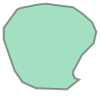

In [146]:
p1.simplify(0.1).intersection(p2.simplify(0.1))

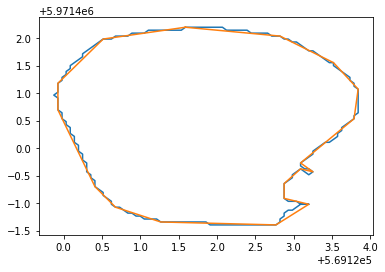

In [145]:
plt.plot(*np.array(p2.exterior.coords).transpose())
plt.plot(*np.array(p2.simplify(0.1).exterior.coords).transpose())
# plt.plot(*np.array(p2.exterior.coords).transpose())

In [127]:
p2=Polygon([(569121.58825, 5971402.19887),
 (569121.5345600001, 5971402.145180001),
 (569121.48087, 5971402.145180001),
 (569121.42718, 5971402.145180001),
 (569121.37349, 5971402.145180001),
 (569121.3198, 5971402.145180001),
 (569121.2661100001, 5971402.145180001),
 (569121.21242, 5971402.145180001),
 (569121.15873, 5971402.145180001),
 (569121.10504, 5971402.145180001),
 (569121.0513500001, 5971402.0914900005),
 (569120.99766, 5971402.0914900005),
 (569120.94397, 5971402.0914900005),
 (569120.89028, 5971402.0914900005),
 (569120.8365900001, 5971402.037800001),
 (569120.7829, 5971402.037800001),
 (569120.72921, 5971402.037800001),
 (569120.67552, 5971402.037800001),
 (569120.6218300001, 5971401.984110001),
 (569120.56814, 5971401.984110001),
 (569120.51445, 5971401.984110001),
 (569120.46076, 5971401.93042),
 (569120.4070700001, 5971401.876730001),
 (569120.35338, 5971401.82304),
 (569120.29969, 5971401.769350001),
 (569120.246, 5971401.71566),
 (569120.246, 5971401.661970001),
 (569120.1923100001, 5971401.60828),
 (569120.13862, 5971401.554590001),
 (569120.08493, 5971401.5009),
 (569120.08493, 5971401.447210001),
 (569120.03124, 5971401.39352),
 (569120.03124, 5971401.339830001),
 (569119.9775500001, 5971401.28614),
 (569119.9775500001, 5971401.232450001),
 (569119.92386, 5971401.1787600005),
 (569119.92386, 5971401.12507),
 (569119.92386, 5971401.071380001),
 (569119.92386, 5971401.01769),
 (569119.87017, 5971400.964000001),
 (569119.92386, 5971400.91031),
 (569119.92386, 5971400.856620001),
 (569119.92386, 5971400.80293),
 (569119.92386, 5971400.749240001),
 (569119.92386, 5971400.69555),
 (569119.9775500001, 5971400.641860001),
 (569119.9775500001, 5971400.58817),
 (569119.9775500001, 5971400.534480001),
 (569120.03124, 5971400.48079),
 (569120.03124, 5971400.427100001),
 (569120.08493, 5971400.3734100005),
 (569120.08493, 5971400.319720001),
 (569120.08493, 5971400.2660300005),
 (569120.13862, 5971400.21234),
 (569120.13862, 5971400.158650001),
 (569120.13862, 5971400.10496),
 (569120.1923100001, 5971400.051270001),
 (569120.1923100001, 5971399.99758),
 (569120.1923100001, 5971399.943890001),
 (569120.246, 5971399.8902),
 (569120.246, 5971399.836510001),
 (569120.246, 5971399.78282),
 (569120.29969, 5971399.729130001),
 (569120.29969, 5971399.67544),
 (569120.29969, 5971399.621750001),
 (569120.29969, 5971399.56806),
 (569120.35338, 5971399.514370001),
 (569120.35338, 5971399.4606800005),
 (569120.4070700001, 5971399.406990001),
 (569120.4070700001, 5971399.353300001),
 (569120.4070700001, 5971399.29961),
 (569120.46076, 5971399.245920001),
 (569120.51445, 5971399.19223),
 (569120.51445, 5971399.138540001),
 (569120.56814, 5971399.08485),
 (569120.6218300001, 5971399.031160001),
 (569120.6218300001, 5971398.97747),
 (569120.67552, 5971398.923780001),
 (569120.72921, 5971398.923780001),
 (569120.7829, 5971398.87009),
 (569120.8365900001, 5971398.816400001),
 (569120.89028, 5971398.816400001),
 (569120.94397, 5971398.76271),
 (569120.99766, 5971398.76271),
 (569121.0513500001, 5971398.709020001),
 (569121.10504, 5971398.709020001),
 (569121.15873, 5971398.709020001),
 (569121.21242, 5971398.709020001),
 (569121.2661100001, 5971398.65533),
 (569121.3198, 5971398.65533),
 (569121.37349, 5971398.65533),
 (569121.42718, 5971398.65533),
 (569121.48087, 5971398.65533),
 (569121.5345600001, 5971398.65533),
 (569121.58825, 5971398.65533),
 (569121.64194, 5971398.65533),
 (569121.69563, 5971398.65533),
 (569121.7493200001, 5971398.65533),
 (569121.80301, 5971398.65533),
 (569121.8567, 5971398.65533),
 (569121.91039, 5971398.601640001),
 (569121.9640800001, 5971398.601640001),
 (569122.01777, 5971398.601640001),
 (569122.07146, 5971398.601640001),
 (569122.12515, 5971398.601640001),
 (569122.1788400001, 5971398.601640001),
 (569122.23253, 5971398.601640001),
 (569122.28622, 5971398.601640001),
 (569122.33991, 5971398.601640001),
 (569122.3936000001, 5971398.601640001),
 (569122.44729, 5971398.601640001),
 (569122.50098, 5971398.601640001),
 (569122.55467, 5971398.601640001),
 (569122.6083600001, 5971398.601640001),
 (569122.66205, 5971398.601640001),
 (569122.71574, 5971398.601640001),
 (569122.76943, 5971398.601640001),
 (569122.8231200001, 5971398.65533),
 (569122.8231200001, 5971398.709020001),
 (569122.87681, 5971398.76271),
 (569122.87681, 5971398.816400001),
 (569122.9305, 5971398.87009),
 (569122.98419, 5971398.87009),
 (569123.0378800001, 5971398.923780001),
 (569123.09157, 5971398.97747),
 (569123.14526, 5971398.97747),
 (569123.19895, 5971398.97747),
 (569123.14526, 5971398.97747),
 (569123.09157, 5971398.97747),
 (569123.0378800001, 5971399.031160001),
 (569122.98419, 5971399.031160001),
 (569122.9305, 5971399.031160001),
 (569122.87681, 5971399.08485),
 (569122.87681, 5971399.138540001),
 (569122.87681, 5971399.19223),
 (569122.87681, 5971399.245920001),
 (569122.87681, 5971399.29961),
 (569122.87681, 5971399.353300001),
 (569122.9305, 5971399.406990001),
 (569122.98419, 5971399.4606800005),
 (569122.98419, 5971399.514370001),
 (569123.0378800001, 5971399.56806),
 (569123.09157, 5971399.621750001),
 (569123.14526, 5971399.56806),
 (569123.19895, 5971399.514370001),
 (569123.2526400001, 5971399.56806),
 (569123.19895, 5971399.621750001),
 (569123.14526, 5971399.621750001),
 (569123.09157, 5971399.67544),
 (569123.09157, 5971399.729130001),
 (569123.14526, 5971399.78282),
 (569123.19895, 5971399.836510001),
 (569123.2526400001, 5971399.8902),
 (569123.2526400001, 5971399.943890001),
 (569123.30633, 5971399.99758),
 (569123.36002, 5971400.051270001),
 (569123.41371, 5971400.10496),
 (569123.4674000001, 5971400.10496),
 (569123.52109, 5971400.158650001),
 (569123.57478, 5971400.21234),
 (569123.57478, 5971400.2660300005),
 (569123.62847, 5971400.319720001),
 (569123.62847, 5971400.3734100005),
 (569123.6821600001, 5971400.427100001),
 (569123.73585, 5971400.48079),
 (569123.78954, 5971400.534480001),
 (569123.78954, 5971400.58817),
 (569123.84323, 5971400.641860001),
 (569123.84323, 5971400.69555),
 (569123.84323, 5971400.749240001),
 (569123.84323, 5971400.80293),
 (569123.84323, 5971400.856620001),
 (569123.84323, 5971400.91031),
 (569123.84323, 5971400.964000001),
 (569123.84323, 5971401.01769),
 (569123.84323, 5971401.071380001),
 (569123.78954, 5971401.12507),
 (569123.78954, 5971401.1787600005),
 (569123.73585, 5971401.232450001),
 (569123.73585, 5971401.28614),
 (569123.6821600001, 5971401.339830001),
 (569123.62847, 5971401.39352),
 (569123.57478, 5971401.447210001),
 (569123.52109, 5971401.5009),
 (569123.52109, 5971401.554590001),
 (569123.4674000001, 5971401.554590001),
 (569123.41371, 5971401.60828),
 (569123.36002, 5971401.661970001),
 (569123.30633, 5971401.71566),
 (569123.2526400001, 5971401.769350001),
 (569123.19895, 5971401.769350001),
 (569123.14526, 5971401.82304),
 (569123.09157, 5971401.876730001),
 (569123.0378800001, 5971401.93042),
 (569122.98419, 5971401.93042),
 (569122.9305, 5971401.984110001),
 (569122.87681, 5971401.984110001),
 (569122.8231200001, 5971402.037800001),
 (569122.76943, 5971402.037800001),
 (569122.71574, 5971402.037800001),
 (569122.66205, 5971402.0914900005),
 (569122.6083600001, 5971402.0914900005),
 (569122.55467, 5971402.0914900005),
 (569122.50098, 5971402.0914900005),
 (569122.44729, 5971402.0914900005),
 (569122.3936000001, 5971402.145180001),
 (569122.33991, 5971402.145180001),
 (569122.28622, 5971402.145180001),
 (569122.23253, 5971402.145180001),
 (569122.1788400001, 5971402.145180001),
 (569122.12515, 5971402.145180001),
 (569122.07146, 5971402.19887),
 (569122.01777, 5971402.19887),
 (569121.9640800001, 5971402.19887),
 (569121.91039, 5971402.19887),
 (569121.8567, 5971402.19887),
 (569121.80301, 5971402.19887),
 (569121.7493200001, 5971402.19887),
 (569121.69563, 5971402.19887),
 (569121.64194, 5971402.19887),
 (569121.58825, 5971402.19887)])

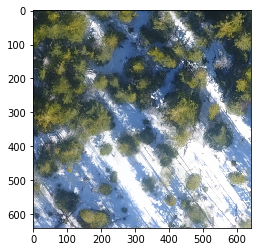

In [31]:
plt.imshow(img[:,:,:3])

In [30]:
predictor(img)

{'instances': Instances(num_instances=0, image_height=640, image_width=640, fields=[pred_boxes = Boxes(tensor([], device='cuda:0', size=(0, 4))), scores = tensor([], device='cuda:0'), pred_classes = tensor([], device='cuda:0', dtype=torch.int64), pred_masks = tensor([], device='cuda:0', size=(0, 640, 640), dtype=torch.uint8), ])}